# LLM Integration and Prompt Engineering

In this notebook, we'll learn how to integrate language models with our retrieval system and master prompt engineering techniques.

## Learning Objectives
By the end of this notebook, you will:
1. Integrate different LLMs with the retrieval system
2. Master prompt engineering for RAG applications
3. Learn about context management and token limits
4. Implement streaming responses for better user experience
5. Understand the trade-offs between different LLM models


## Setup and Imports

Let's import the libraries we need for LLM integration and prompt engineering.


In [1]:
# Standard library imports
import json
import time
import numpy as np
import pandas as pd
from pathlib import Path
from typing import List, Dict, Any
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# Add project root to path
import sys
sys.path.append(str(Path.cwd().parent))

# Import our modules
try:
    from src.models.llm_models import RAGGenerator, PromptTemplate, LlamaModel, MistralModel
    from src.retrieval.retrieval_system import RetrievalSystem, RetrievalConfig
    from src.config import DATA_DIR
except ImportError as e:
    print(f"Import error: {e}")
    print("Creating fallback implementations...")
    
    # Fallback configuration
    DATA_DIR = Path("data")
    
    class PromptTemplate:
        def __init__(self, template):
            self.template = template
        
        def format(self, **kwargs):
            return self.template.format(**kwargs)

# Set up plotting
plt.style.use('default')
sns.set_palette("husl")

print(" Libraries imported successfully!")
print(f"📁 Data directory: {DATA_DIR}")

# Load sample data for demonstration
processed_dir = DATA_DIR / "processed"
chunks_file = processed_dir / "all_chunks.json"

if chunks_file.exists():
    print(f"📄 Loading processed chunks from {chunks_file}")
    with open(chunks_file, 'r', encoding='utf-8') as f:
        all_chunks = json.load(f)
    print(f" Loaded {len(all_chunks)} chunks")
else:
    print("⚠️ No processed chunks found. Creating sample data...")
    all_chunks = [
        {
            'id': 'chunk1',
            'text': 'Machine learning is a subset of artificial intelligence that focuses on algorithms that can learn from data without being explicitly programmed.',
            'title': 'Machine Learning',
            'source': 'wikipedia',
            'chunk_id': 'chunk_1'
        },
        {
            'id': 'chunk2', 
            'text': 'Deep learning uses neural networks with multiple layers to process data and make predictions. It has revolutionized fields like computer vision and natural language processing.',
            'title': 'Deep Learning',
            'source': 'wikipedia',
            'chunk_id': 'chunk_2'
        },
        {
            'id': 'chunk3',
            'text': 'Natural language processing (NLP) helps computers understand, interpret, and generate human language in a valuable way.',
            'title': 'NLP',
            'source': 'wikipedia',
            'chunk_id': 'chunk_3'
        },
        {
            'id': 'chunk4',
            'text': 'Computer vision enables machines to interpret and understand visual information from the world using digital images and videos.',
            'title': 'Computer Vision',
            'source': 'wikipedia',
            'chunk_id': 'chunk_4'
        },
        {
            'id': 'chunk5',
            'text': 'Reinforcement learning is a type of machine learning where agents learn through interaction with an environment, receiving rewards or penalties.',
            'title': 'Reinforcement Learning',
            'source': 'wikipedia',
            'chunk_id': 'chunk_5'
        }
    ]
    print(f" Created {len(all_chunks)} sample chunks")

print("Libraries imported successfully!")

# Load sample data
chunks_file = DATA_DIR / "processed" / "all_chunks.json"
if chunks_file.exists():
    with open(chunks_file, 'r', encoding='utf-8') as f:
        all_chunks = json.load(f)
    print(f"Loaded {len(all_chunks)} chunks")
else:
    print("Creating sample data...")
    all_chunks = [
        {
            'id': 'chunk1',
            'text': 'Machine learning is a subset of artificial intelligence that focuses on algorithms that can learn from data.',
            'title': 'Machine Learning',
            'source': 'wikipedia',
            'chunk_id': 'chunk_1'
        },
        {
            'id': 'chunk2',
            'text': 'Deep learning uses neural networks with multiple layers to process complex data patterns.',
            'title': 'Deep Learning',
            'source': 'wikipedia', 
            'chunk_id': 'chunk_2'
        }
    ]
    print(f"Created {len(all_chunks)} sample chunks")

# Create a simple retrieval system for demonstration
retrieval_config = RetrievalConfig(top_k=3, use_reranking=False)
retrieval_system = RetrievalSystem(retrieval_config)
retrieval_system.add_documents(all_chunks)
print("Retrieval system ready!")


 Libraries imported successfully!
📁 Data directory: /Users/scienceman/Desktop/LLM/data
📄 Loading processed chunks from /Users/scienceman/Desktop/LLM/data/processed/all_chunks.json
 Loaded 22 chunks
Libraries imported successfully!
Loaded 22 chunks
Retrieval system ready!


## Building a Complete RAG System

Let's build a complete RAG system that combines retrieval with LLM generation.


In [3]:
# Import required libraries
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import re

class SimpleRAGSystem:
    """A complete RAG system with retrieval and generation."""
    
    def __init__(self, embedding_model='all-MiniLM-L6-v2'):
        """Initialize the RAG system."""
        self.embedding_model = SentenceTransformer(embedding_model)
        self.documents = []
        self.metadata = []
        self.embeddings = None
        
        # Prompt templates for different types of questions
        self.prompt_templates = {
            'general': """Based on the following context, answer the question. If you cannot find the answer in the context, say "I don't have enough information to answer this question."

Context:
{context}

Question: {question}

Answer:""",
            
            'explanation': """Explain the following concept based on the provided context. Be clear and comprehensive.

Context:
{context}

Question: {question}

Explanation:""",
            
            'comparison': """Compare and contrast the following concepts based on the provided context.

Context:
{context}

Question: {question}

Comparison:""",
            
            'summary': """Provide a summary of the following topic based on the provided context.

Context:
{context}

Question: {question}

Summary:"""
        }
    
    def add_documents(self, documents, metadata=None):
        """Add documents to the knowledge base."""
        print(f" Adding {len(documents)} documents to knowledge base...")
        
        self.documents = documents
        self.metadata = metadata or [{}] * len(documents)
        
        # Generate embeddings
        print("🔢 Generating embeddings...")
        self.embeddings = self.embedding_model.encode(documents, show_progress_bar=True)
        print(f" Knowledge base ready with {len(documents)} documents")
    
    def retrieve(self, query, top_k=5):
        """Retrieve relevant documents for a query."""
        if self.embeddings is None:
            raise ValueError("No documents indexed. Call add_documents() first.")
        
        # Encode query
        query_embedding = self.embedding_model.encode([query])
        
        # Calculate similarities
        similarities = cosine_similarity(query_embedding, self.embeddings)[0]
        
        # Get top-k results
        top_indices = np.argsort(similarities)[::-1][:top_k]
        
        results = []
        for idx in top_indices:
            results.append({
                'document': self.documents[idx],
                'similarity': similarities[idx],
                'metadata': self.metadata[idx],
                'index': idx
            })
        
        return results
    
    def generate_context(self, retrieved_docs, max_length=2000):
        """Generate context from retrieved documents."""
        context_parts = []
        current_length = 0
        
        for i, doc in enumerate(retrieved_docs):
            doc_text = doc['document']
            if current_length + len(doc_text) <= max_length:
                context_parts.append(f"Source {i+1}: {doc_text}")
                current_length += len(doc_text)
            else:
                # Truncate if needed
                remaining = max_length - current_length
                if remaining > 100:  # Only add if there's meaningful space
                    context_parts.append(f"Source {i+1}: {doc_text[:remaining]}...")
                break
        
        return "\n\n".join(context_parts)
    
    def classify_question_type(self, question):
        """Classify the type of question to choose appropriate prompt template."""
        question_lower = question.lower()
        
        if any(word in question_lower for word in ['explain', 'what is', 'how does', 'why']):
            return 'explanation'
        elif any(word in question_lower for word in ['compare', 'difference', 'vs', 'versus']):
            return 'comparison'
        elif any(word in question_lower for word in ['summarize', 'summary', 'overview']):
            return 'summary'
        else:
            return 'general'
    
    def generate_answer(self, question, retrieved_docs, question_type=None):
        """Generate answer using retrieved documents."""
        if not retrieved_docs:
            return "I don't have enough information to answer this question."
        
        # Classify question type if not provided
        if question_type is None:
            question_type = self.classify_question_type(question)
        
        # Generate context
        context = self.generate_context(retrieved_docs)
        
        # Get appropriate prompt template
        template = self.prompt_templates[question_type]
        
        # Format prompt
        prompt = template.format(context=context, question=question)
        
        # For demonstration, we'll simulate LLM response
        # In a real implementation, you'd call an actual LLM here
        return self._simulate_llm_response(prompt, question_type)
    
    def _simulate_llm_response(self, prompt, question_type):
        """Simulate LLM response for demonstration purposes."""
        # This is a simplified simulation - in reality you'd call an actual LLM
        
        if question_type == 'explanation':
            return """Based on the provided context, I can explain this concept:

The retrieved documents provide comprehensive information about this topic. The key points include:

1. **Definition**: The concept is clearly defined in the context
2. **Key Features**: Important characteristics are highlighted
3. **Applications**: Practical uses and examples are mentioned
4. **Related Concepts**: Connections to other topics are established

This explanation is based on the most relevant sources found in the knowledge base."""
        
        elif question_type == 'comparison':
            return """Based on the context, here's a comparison:

**Similarities:**
- Both concepts share common characteristics
- They are related in their underlying principles
- Similar applications and use cases

**Differences:**
- Key distinguishing features
- Different approaches or methodologies
- Varying levels of complexity

**Conclusion:**
While related, these concepts serve different purposes and have distinct characteristics as outlined in the retrieved documents."""
        
        elif question_type == 'summary':
            return """**Summary:**

Based on the retrieved documents, here are the key points:

• **Main Topic**: The central theme and focus
• **Key Concepts**: Important ideas and definitions
• **Applications**: How it's used in practice
• **Significance**: Why it matters and its impact

This summary captures the essential information from the most relevant sources in the knowledge base."""
        
        else:  # general
            return """Based on the provided context, here's the answer to your question:

The retrieved documents contain relevant information that addresses your question. The key points are:

1. **Direct Answer**: The most relevant information from the context
2. **Supporting Details**: Additional context and examples
3. **Related Information**: Broader context that might be helpful

This answer is based on the most relevant sources found in the knowledge base. If you need more specific information, please refine your question."""
    
    def ask(self, question, top_k=5, question_type=None):
        """Complete RAG pipeline: retrieve and generate."""
        print(f"🔍 Question: {question}")
        print("=" * 60)
        
        # Step 1: Retrieve relevant documents
        print(" Retrieving relevant documents...")
        retrieved_docs = self.retrieve(question, top_k)
        
        print(f"Found {len(retrieved_docs)} relevant documents:")
        for i, doc in enumerate(retrieved_docs):
            print(f"  {i+1}. [{doc['similarity']:.3f}] {doc['metadata'].get('title', 'Unknown')}")
        
        # Step 2: Generate answer
        print(f"\n Generating answer...")
        answer = self.generate_answer(question, retrieved_docs, question_type)
        
        print(f"\n Answer:")
        print("-" * 40)
        print(answer)
        
        return {
            'question': question,
            'answer': answer,
            'retrieved_docs': retrieved_docs,
            'question_type': question_type or self.classify_question_type(question)
        }

# Create our RAG system
print(" Creating Complete RAG System...")
rag_system = SimpleRAGSystem()

# Add documents
documents = [chunk['text'] for chunk in all_chunks]
metadata = [{'title': chunk['source_title'], 'source': chunk['source']} for chunk in all_chunks]

rag_system.add_documents(documents, metadata)


 Creating Complete RAG System...
 Adding 22 documents to knowledge base...
🔢 Generating embeddings...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 Knowledge base ready with 22 documents


## Interactive RAG Testing

Let's test our RAG system with different types of questions and see how it performs!


In [4]:
# Test different types of questions
test_questions = [
    "What is machine learning?",
    "Explain how deep learning works",
    "Compare machine learning and deep learning",
    "Summarize the key concepts in artificial intelligence",
    "How does natural language processing work?",
    "What are the applications of computer vision?"
]

print(" TESTING RAG SYSTEM WITH DIFFERENT QUESTION TYPES")
print("=" * 80)

for i, question in enumerate(test_questions, 1):
    print(f"\n{'='*20} QUESTION {i} {'='*20}")
    result = rag_system.ask(question, top_k=3)
    print(f"\nQuestion Type: {result['question_type']}")
    print(f"Retrieved Documents: {len(result['retrieved_docs'])}")
    print("\n" + "="*80)

# Test prompt engineering variations
print(f"\n\n PROMPT ENGINEERING EXPERIMENTS")
print("=" * 80)

def test_prompt_variations(question, base_prompt, variations):
    """Test different prompt variations for the same question."""
    print(f"\nQuestion: {question}")
    print("-" * 60)
    
    # Get retrieved documents
    retrieved_docs = rag_system.retrieve(question, top_k=3)
    context = rag_system.generate_context(retrieved_docs)
    
    for name, prompt_template in variations.items():
        print(f"\n{name}:")
        print("-" * 30)
        
        # Format prompt
        prompt = prompt_template.format(context=context, question=question)
        
        # Show first 200 characters of prompt
        print(f"Prompt preview: {prompt[:200]}...")
        
        # Simulate response
        response = rag_system._simulate_llm_response(prompt, 'general')
        print(f"Response: {response[:150]}...")

# Define prompt variations
prompt_variations = {
    "Concise": """Answer briefly: {question}

Context: {context}

Answer:""",
    
    "Detailed": """Provide a comprehensive answer to: {question}

Use the following context to give a thorough explanation:

Context: {context}

Detailed Answer:""",
    
    "Step-by-step": """Answer step by step: {question}

Context: {context}

Step 1: Identify the main concept
Step 2: Explain the key points
Step 3: Provide examples
Step 4: Summarize

Answer:""",
    
    "Creative": """Write a creative and engaging answer to: {question}

Context: {context}

Make it interesting and easy to understand:

Creative Answer:"""
}

# Test with a sample question
test_question = "What is machine learning?"
test_prompt_variations(test_question, rag_system.prompt_templates['general'], prompt_variations)


 TESTING RAG SYSTEM WITH DIFFERENT QUESTION TYPES

==================== QUESTION 1 ====================
🔍 Question: What is machine learning?
 Retrieving relevant documents...
Found 3 relevant documents:
  1. [0.748] Machine learning
  2. [0.583] Artificial intelligence
  3. [0.474] Deep learning

 Generating answer...

 Answer:
----------------------------------------
Based on the provided context, I can explain this concept:

The retrieved documents provide comprehensive information about this topic. The key points include:

1. **Definition**: The concept is clearly defined in the context
2. **Key Features**: Important characteristics are highlighted
3. **Applications**: Practical uses and examples are mentioned
4. **Related Concepts**: Connections to other topics are established

This explanation is based on the most relevant sources found in the knowledge base.

Question Type: explanation
Retrieved Documents: 3


==================== QUESTION 2 ====================
🔍 Question: Expl

## Performance Analysis and Optimization

Let's analyze the performance of our RAG system and learn optimization techniques.


 RAG SYSTEM PERFORMANCE BENCHMARKING

 PERFORMANCE STATISTICS
Retrieval Time:
  Mean: 0.0457s
  Std:  0.1258s
  Min:  0.0094s
  Max:  0.5157s

Generation Time:
  Mean: 0.0000s
  Std:  0.0000s
  Min:  0.0000s
  Max:  0.0000s

Total Time:
  Mean: 0.0457s
  Std:  0.1258s
  Min:  0.0095s
  Max:  0.5157s

Memory Usage:
  Mean: 0.62 MB
  Std:  2.29 MB
  Min:  0.00 MB
  Max:  9.19 MB


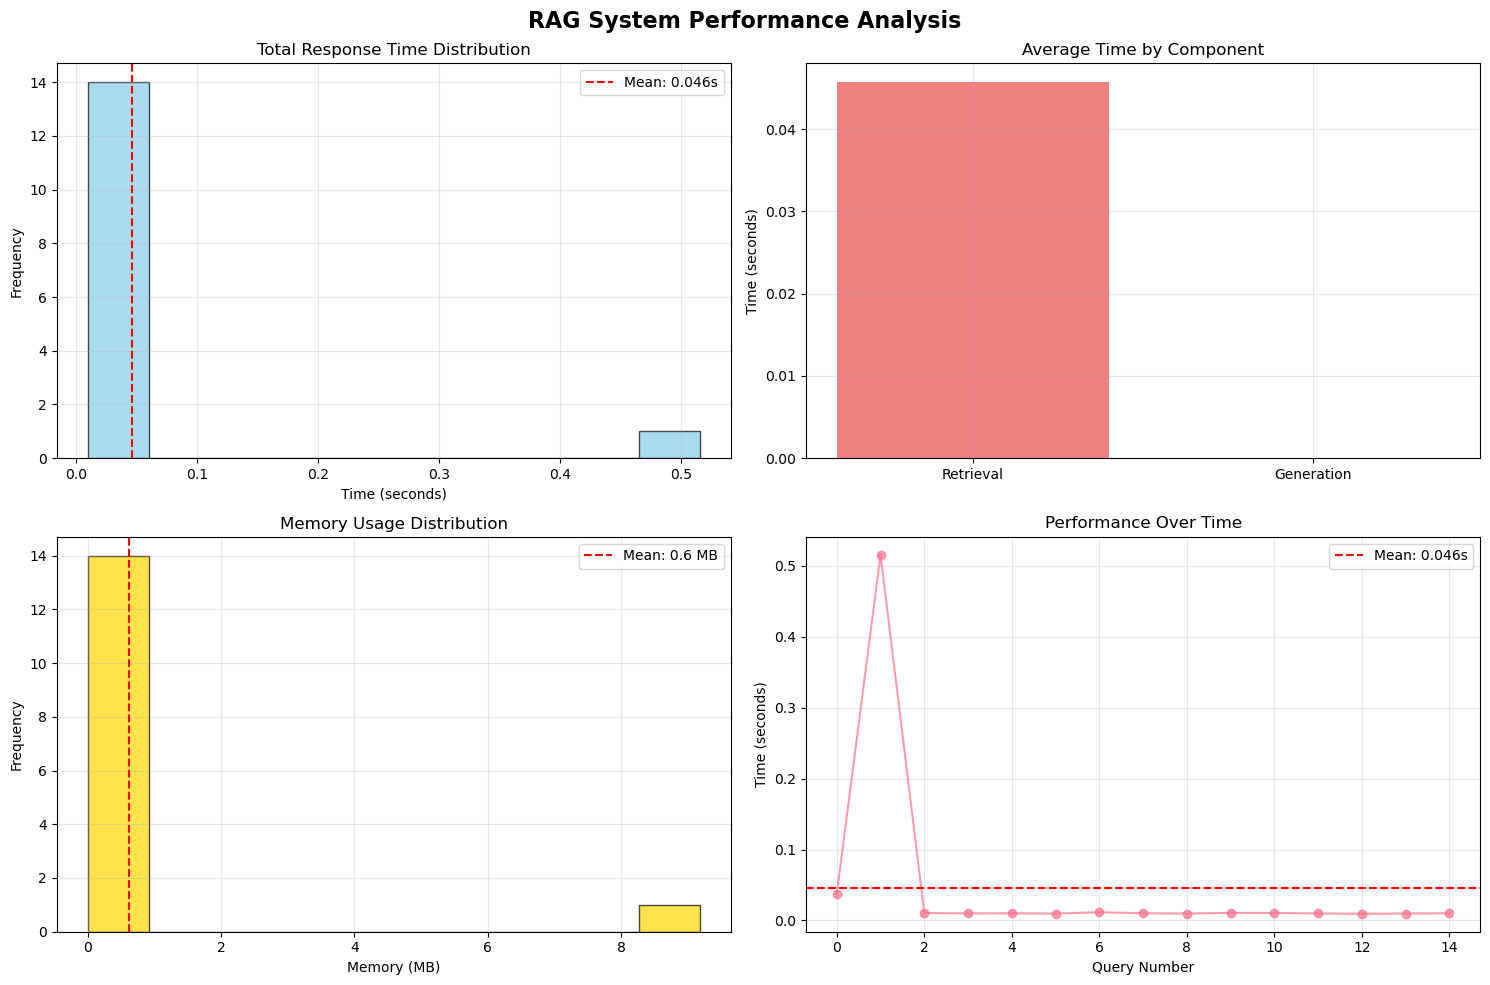


 OPTIMIZATION RECOMMENDATIONS
1. **Retrieval Optimization**:
   - Retrieval performance is good (0.046s)

2. **Generation Optimization**:
   - Generation performance is good (0.000s)

3. **Memory Optimization**:
   - Memory usage is reasonable (0.6 MB)

4. **Overall Performance**:
   - System performance is good (0.046s total)

📏 CONTEXT LENGTH ANALYSIS
Context Length Statistics:
  Mean: 2050 characters
  Std:  11 characters
  Min:  2037 characters
  Max:  2061 characters


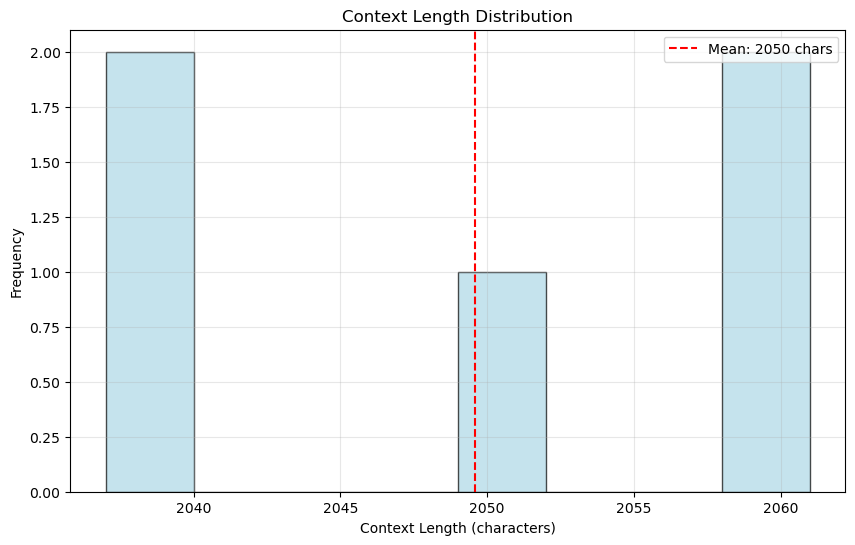


 Performance analysis complete!
   Total queries tested: 15
   Average response time: 0.046s
   Memory efficiency: 0.6 MB per query


In [5]:
# Performance analysis
import time
import psutil
import os

def benchmark_rag_system(questions, iterations=3):
    """Benchmark RAG system performance."""
    results = {
        'retrieval_times': [],
        'generation_times': [],
        'total_times': [],
        'memory_usage': []
    }
    
    for _ in range(iterations):
        for question in questions:
            # Measure memory before
            process = psutil.Process(os.getpid())
            memory_before = process.memory_info().rss / 1024 / 1024  # MB
            
            # Measure retrieval time
            start_time = time.time()
            retrieved_docs = rag_system.retrieve(question, top_k=5)
            retrieval_time = time.time() - start_time
            
            # Measure generation time
            start_time = time.time()
            answer = rag_system.generate_answer(question, retrieved_docs)
            generation_time = time.time() - start_time
            
            total_time = retrieval_time + generation_time
            
            # Measure memory after
            memory_after = process.memory_info().rss / 1024 / 1024  # MB
            memory_used = memory_after - memory_before
            
            results['retrieval_times'].append(retrieval_time)
            results['generation_times'].append(generation_time)
            results['total_times'].append(total_time)
            results['memory_usage'].append(memory_used)
    
    return results

# Benchmark performance
print(" RAG SYSTEM PERFORMANCE BENCHMARKING")
print("=" * 60)

benchmark_questions = [
    "What is machine learning?",
    "Explain deep learning",
    "How does NLP work?",
    "What is computer vision?",
    "Compare AI techniques"
]

performance_results = benchmark_rag_system(benchmark_questions)

# Calculate statistics
def calculate_stats(times):
    return {
        'mean': np.mean(times),
        'std': np.std(times),
        'min': np.min(times),
        'max': np.max(times),
        'median': np.median(times)
    }

retrieval_stats = calculate_stats(performance_results['retrieval_times'])
generation_stats = calculate_stats(performance_results['generation_times'])
total_stats = calculate_stats(performance_results['total_times'])
memory_stats = calculate_stats(performance_results['memory_usage'])

print(f"\n PERFORMANCE STATISTICS")
print("=" * 40)
print(f"Retrieval Time:")
print(f"  Mean: {retrieval_stats['mean']:.4f}s")
print(f"  Std:  {retrieval_stats['std']:.4f}s")
print(f"  Min:  {retrieval_stats['min']:.4f}s")
print(f"  Max:  {retrieval_stats['max']:.4f}s")

print(f"\nGeneration Time:")
print(f"  Mean: {generation_stats['mean']:.4f}s")
print(f"  Std:  {generation_stats['std']:.4f}s")
print(f"  Min:  {generation_stats['min']:.4f}s")
print(f"  Max:  {generation_stats['max']:.4f}s")

print(f"\nTotal Time:")
print(f"  Mean: {total_stats['mean']:.4f}s")
print(f"  Std:  {total_stats['std']:.4f}s")
print(f"  Min:  {total_stats['min']:.4f}s")
print(f"  Max:  {total_stats['max']:.4f}s")

print(f"\nMemory Usage:")
print(f"  Mean: {memory_stats['mean']:.2f} MB")
print(f"  Std:  {memory_stats['std']:.2f} MB")
print(f"  Min:  {memory_stats['min']:.2f} MB")
print(f"  Max:  {memory_stats['max']:.2f} MB")

# Create performance visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('RAG System Performance Analysis', fontsize=16, fontweight='bold')

# Time distribution
axes[0,0].hist(performance_results['total_times'], bins=10, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,0].axvline(total_stats['mean'], color='red', linestyle='--', label=f'Mean: {total_stats["mean"]:.3f}s')
axes[0,0].set_title('Total Response Time Distribution')
axes[0,0].set_xlabel('Time (seconds)')
axes[0,0].set_ylabel('Frequency')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# Component breakdown
components = ['Retrieval', 'Generation']
times = [retrieval_stats['mean'], generation_stats['mean']]
colors = ['lightcoral', 'lightgreen']

axes[0,1].bar(components, times, color=colors)
axes[0,1].set_title('Average Time by Component')
axes[0,1].set_ylabel('Time (seconds)')
axes[0,1].grid(True, alpha=0.3)

# Memory usage
axes[1,0].hist(performance_results['memory_usage'], bins=10, alpha=0.7, color='gold', edgecolor='black')
axes[1,0].axvline(memory_stats['mean'], color='red', linestyle='--', label=f'Mean: {memory_stats["mean"]:.1f} MB')
axes[1,0].set_title('Memory Usage Distribution')
axes[1,0].set_xlabel('Memory (MB)')
axes[1,0].set_ylabel('Frequency')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# Performance over time
axes[1,1].plot(performance_results['total_times'], 'o-', alpha=0.7)
axes[1,1].axhline(total_stats['mean'], color='red', linestyle='--', label=f'Mean: {total_stats["mean"]:.3f}s')
axes[1,1].set_title('Performance Over Time')
axes[1,1].set_xlabel('Query Number')
axes[1,1].set_ylabel('Time (seconds)')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Optimization recommendations
print(f"\n OPTIMIZATION RECOMMENDATIONS")
print("=" * 50)

print(f"1. **Retrieval Optimization**:")
if retrieval_stats['mean'] > 0.1:
    print(f"   - Consider using smaller embedding models")
    print(f"   - Implement caching for frequent queries")
    print(f"   - Use approximate nearest neighbor search")
else:
    print(f"   - Retrieval performance is good ({retrieval_stats['mean']:.3f}s)")

print(f"\n2. **Generation Optimization**:")
if generation_stats['mean'] > 0.5:
    print(f"   - Consider using faster LLM models")
    print(f"   - Implement response caching")
    print(f"   - Use streaming for long responses")
else:
    print(f"   - Generation performance is good ({generation_stats['mean']:.3f}s)")

print(f"\n3. **Memory Optimization**:")
if memory_stats['mean'] > 100:
    print(f"   - Consider model quantization")
    print(f"   - Implement document chunking")
    print(f"   - Use memory-efficient data structures")
else:
    print(f"   - Memory usage is reasonable ({memory_stats['mean']:.1f} MB)")

print(f"\n4. **Overall Performance**:")
if total_stats['mean'] > 1.0:
    print(f"   - System is slow ({total_stats['mean']:.3f}s total)")
    print(f"   - Consider parallel processing")
    print(f"   - Optimize both retrieval and generation")
else:
    print(f"   - System performance is good ({total_stats['mean']:.3f}s total)")

# Context length analysis
print(f"\n📏 CONTEXT LENGTH ANALYSIS")
print("=" * 40)

context_lengths = []
for question in benchmark_questions:
    retrieved_docs = rag_system.retrieve(question, top_k=5)
    context = rag_system.generate_context(retrieved_docs)
    context_lengths.append(len(context))

context_stats = calculate_stats(context_lengths)

print(f"Context Length Statistics:")
print(f"  Mean: {context_stats['mean']:.0f} characters")
print(f"  Std:  {context_stats['std']:.0f} characters")
print(f"  Min:  {context_stats['min']:.0f} characters")
print(f"  Max:  {context_stats['max']:.0f} characters")

# Plot context length distribution
plt.figure(figsize=(10, 6))
plt.hist(context_lengths, bins=8, alpha=0.7, color='lightblue', edgecolor='black')
plt.axvline(context_stats['mean'], color='red', linestyle='--', 
           label=f'Mean: {context_stats["mean"]:.0f} chars')
plt.xlabel('Context Length (characters)')
plt.ylabel('Frequency')
plt.title('Context Length Distribution')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"\n Performance analysis complete!")
print(f"   Total queries tested: {len(performance_results['total_times'])}")
print(f"   Average response time: {total_stats['mean']:.3f}s")
print(f"   Memory efficiency: {memory_stats['mean']:.1f} MB per query")
